In [18]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [20]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 100 # number of different omega*
t0 = 10 # starting time
max_iters = 300 # maximum number of iterations before breaking

In [21]:
net = nn_resampler(num_bins,num_bins)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [22]:
true_omegas = []
nn_preds = []
nn_data = []

for i in range(n_iters): 
    
    true_omega = np.random.uniform(low=-1, high =1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1
        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break         
    
    nn_data.append(smc.data)
    nn_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))

True omega: 0.745197, prediction by NN: 2.406387, num of resample calls: 68. Failed
True omega: -0.741015, prediction by NN: -0.885297, num of resample calls: 67
True omega: -0.135716, prediction by NN: -0.059986, num of resample calls: 67
True omega: -2.355407, prediction by NN: -1.333442, num of resample calls: 65. Failed
True omega: 2.069424, prediction by NN: 2.328330, num of resample calls: 67
True omega: -2.129952, prediction by NN: -2.138327, num of resample calls: 66
True omega: -1.553366, prediction by NN: -0.787061, num of resample calls: 67
True omega: -0.530588, prediction by NN: -0.551307, num of resample calls: 66
True omega: -1.100513, prediction by NN: -1.057637, num of resample calls: 65
True omega: -2.867994, prediction by NN: 1.018782, num of resample calls: 67. Failed
True omega: -2.981931, prediction by NN: -2.786580, num of resample calls: 65
True omega: -1.473055, prediction by NN: 0.460984, num of resample calls: 66. Failed
True omega: 1.523255, prediction by NN

In [23]:
nn_mse = np.mean( (np.array(true_omegas) - np.array(nn_preds) ) ** 2 )
print(nn_mse)

5.421706795841878


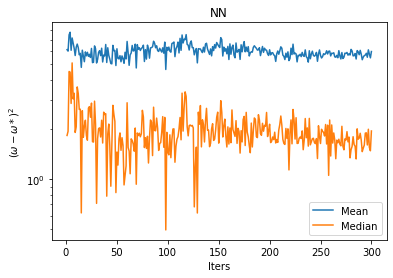

In [24]:
nn_data_squared = ( np.array(nn_data) - np.array(true_omegas).reshape(-1,1)) ** 2 
nn_data_mean = np.mean(nn_data_squared, axis=0)
nn_data_median = np.median(nn_data_squared, axis =0)

num_data_points = nn_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_median, label='Median')
plt.legend()
plt.title("NN")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.show()

## Gaussian Bin Resampler

In [25]:
true_omegas = []
gb_preds = []
gb_data = []

for i in range(n_iters): 
    
    true_omega = np.random.uniform(low=-1, high =1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
        
        smc.nn_bins_to_particles(bins[np.newaxis,:],edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break         
    
    gb_data.append(smc.data)
    gb_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by GB: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    else:
        print("True omega: {:f}, prediction by GB: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))

True omega: -3.070150, prediction by GB: -3.076125, num of resample calls: 65
True omega: 1.038746, prediction by GB: 0.451487, num of resample calls: 67
True omega: 2.571061, prediction by GB: 2.530574, num of resample calls: 64
True omega: -2.332283, prediction by GB: -2.331402, num of resample calls: 64
True omega: -0.513484, prediction by GB: -0.697364, num of resample calls: 64
True omega: -0.962058, prediction by GB: -0.944501, num of resample calls: 66
True omega: -1.528506, prediction by GB: -1.508543, num of resample calls: 66
True omega: 2.661082, prediction by GB: 2.550483, num of resample calls: 68
True omega: -3.112786, prediction by GB: -3.085210, num of resample calls: 65
True omega: -3.115463, prediction by GB: -3.115463, num of resample calls: 25
True omega: -2.176645, prediction by GB: -1.619022, num of resample calls: 66
True omega: 1.396236, prediction by GB: 1.302763, num of resample calls: 66
True omega: -2.622663, prediction by GB: -2.622663, num of resample call

In [26]:
gb_mse = np.mean( (np.array(true_omegas) - np.array(gb_preds) ) ** 2 )
print(gb_mse)

1.7163598873104868


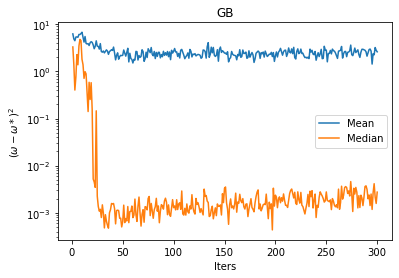

In [27]:
gb_data_squared = ( np.array(gb_data) - np.array(true_omegas).reshape(-1,1)) ** 2 
gb_data_mean = np.mean(gb_data_squared, axis=0)
gb_data_median = np.median(gb_data_squared, axis =0)

num_data_points = gb_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), gb_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), gb_data_median, label='Median')
plt.legend()
plt.title("GB")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.show()

## Liu-West resampler

In [28]:
true_omegas = []
lw_preds = []
lw_data = []

for i in range(n_iters): 
    true_omega = np.random.uniform(low=-1, high=1) * np.pi
    
    true_omegas.append(true_omega)
    smc = phase_est_smc(true_omega, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_preds.append(smc.curr_omega_est)
    
    if np.abs(true_omega - smc.curr_omega_est) > 1:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}. Failed".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    
    else:
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(true_omega,
                                                                                            smc.curr_omega_est,
                                                                                            resample_counts))
    

True omega: -2.483155, prediction by NN: -0.521730, num of resample calls: 69. Failed
True omega: 0.354705, prediction by NN: 2.586255, num of resample calls: 69. Failed
True omega: -2.679600, prediction by NN: 2.710159, num of resample calls: 68. Failed
True omega: -2.394410, prediction by NN: -0.559620, num of resample calls: 69. Failed
True omega: 0.216283, prediction by NN: 0.457535, num of resample calls: 68
True omega: -0.229370, prediction by NN: -1.561029, num of resample calls: 68. Failed
True omega: 2.272743, prediction by NN: -0.075676, num of resample calls: 69. Failed
True omega: -1.325896, prediction by NN: 0.414894, num of resample calls: 68. Failed
True omega: -1.020459, prediction by NN: -1.487582, num of resample calls: 67
True omega: 1.527198, prediction by NN: -0.135042, num of resample calls: 67. Failed
True omega: 1.739974, prediction by NN: -0.585659, num of resample calls: 69. Failed
True omega: -1.047772, prediction by NN: 0.687563, num of resample calls: 68. F

In [29]:
lw_mse = np.mean( (np.array(true_omegas) - np.array(lw_preds)) ** 2 )
print(lw_mse)

2.8837299065078565


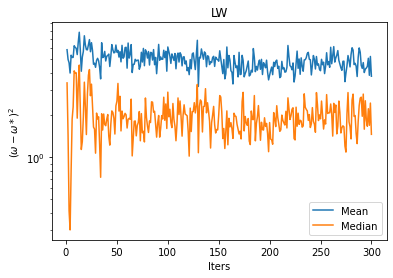

In [30]:
lw_data_squared = ( np.array(lw_data) - np.array(true_omegas).reshape(-1,1)) ** 2 
lw_data_mean = np.mean(lw_data_squared, axis=0)
lw_data_median = np.median(lw_data_squared, axis =0)

num_data_points = lw_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_median, label='Median')
plt.legend()
plt.title("LW")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.yscale('log')
plt.show()

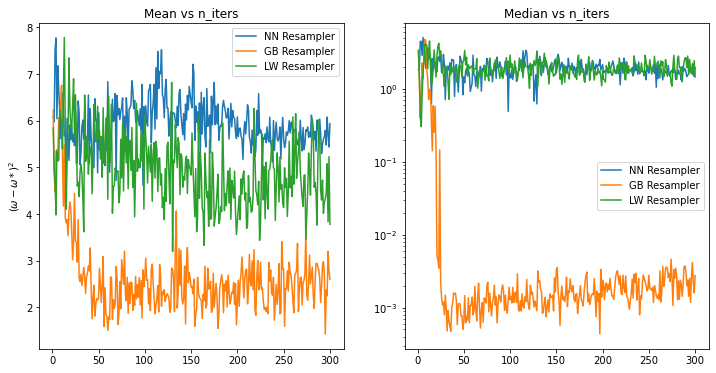

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
x_iters = np.arange(1,num_data_points+1, dtype=int)
ax1.plot(x_iters, nn_data_mean, label='NN Resampler')
ax1.plot(x_iters, gb_data_mean, label='GB Resampler')
ax1.plot(x_iters, lw_data_mean, label='LW Resampler')
ax1.set_title("Mean vs n_iters")
ax1.set_ylabel("$(\omega - \omega*)^2$")
ax1.legend()

ax2.plot(x_iters, nn_data_median, label='NN Resampler')
ax2.plot(x_iters, gb_data_median, label='GB Resampler')
ax2.plot(x_iters, lw_data_median, label='LW Resampler')
ax2.set_title("Median vs n_iters")
ax2.set_yscale("log")
ax2.legend()

plt.show()